### 1. Initialization

In [14]:
# Importing libraries
import pickle
from esda.moran import Moran
from libpysal.weights import Queen, KNN, W
import seaborn as sb
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from clustergram import Clustergram
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed
from multiprocessing.pool import ThreadPool 

In [2]:
# Import population grid of respective urban area
popgridmanchester = gpd.read_file("popgridmanchesterlatest.gpkg")

# Selecting variables (columns) of interest
popgridsub = popgridmanchester.iloc[:,[4,11,18,21,22,25,27,30,31]+list(range(36,60))]
cluster_variables = [col for col in popgridsub.columns if col != "geometry"]

# Converting population density per buffer to km2, will do this for the main gdf
popgridsub.buffer_pop_density = popgridsub.buffer_pop_density*1000000

# Remove nans and inf values, resetting index
popgridsub = popgridsub.replace([np.inf, -np.inf], np.nan)
popgridsub = popgridsub.dropna()
popgridsub = popgridsub.reset_index()

# Robust scaling due to the range of values differing between variables
popgridsub_scaled = scale(popgridsub[cluster_variables])

c:\Users\Gebruiker\anaconda3\envs\ssml\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### 2. Loading and running K-Means from Clustergram Pickle with 9 clusters

In [9]:
with open('clustergram_kmeans.pickle','rb') as f:
    cgram_kmeans = pickle.load(f)

c:\Users\Gebruiker\anaconda3\envs\ssml\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator PCA from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<AxesSubplot: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

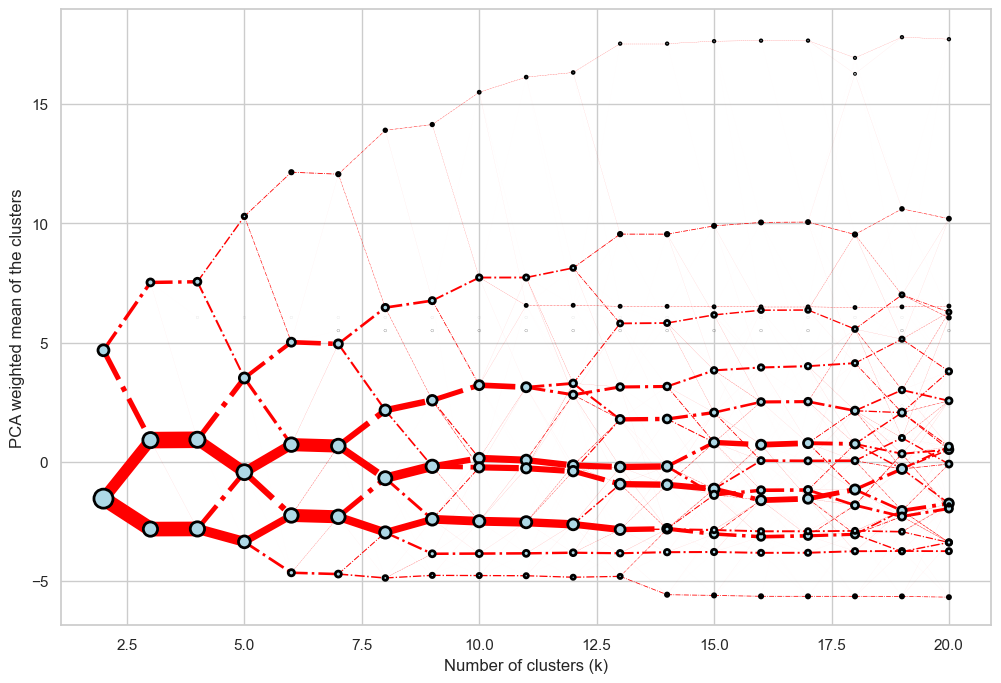

In [10]:
# plot cgram
sb.set(style='whitegrid')

cgram_kmeans.plot(
    size=0.5,
    linewidth=0.5,
    cluster_style={"color": "lightblue", "edgecolor": "black"},
    line_style={"color": "red", "linestyle": "-."},
    figsize=(12, 8)
)

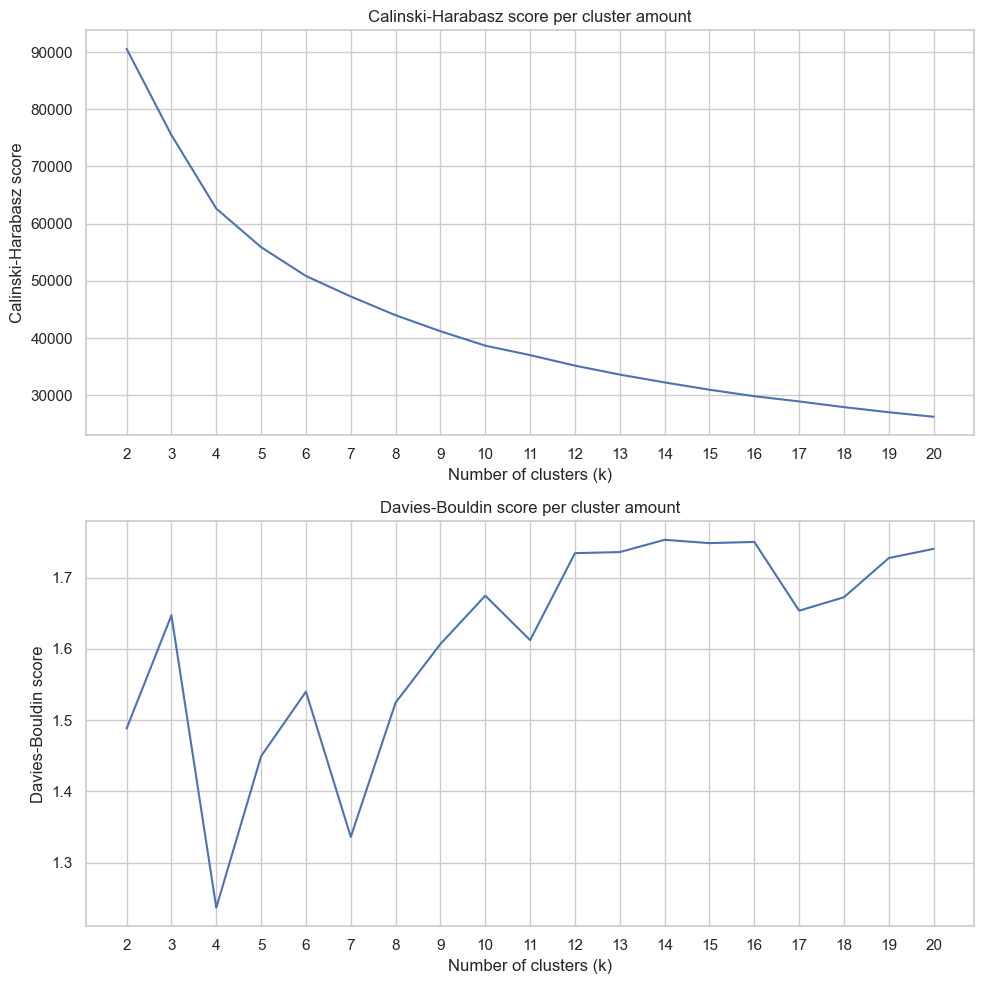

In [11]:
# getting the scores
kmeansch = cgram_kmeans.calinski_harabasz_score()
kmeansdb = cgram_kmeans.davies_bouldin_score()

# Plotting both the Silhouette score and the Calinski-Harabasz score per cluster amount
fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].plot(K, kmeansch)
axs[0].set_xlabel("Number of clusters (k)")
axs[0].set_ylabel("Calinski-Harabasz score")
axs[0].grid(True)
axs[0].set_xticks(range(2,21))
axs[0].set_title('Calinski-Harabasz score per cluster amount')
axs[1].plot(K, kmeansdb)
axs[1].set_xlabel("Number of clusters (k)")
axs[1].set_ylabel("Davies-Bouldin score")
axs[1].grid(True)
axs[1].set_xticks(range(2,21))
axs[1].set_title('Davies-Bouldin score per cluster amount')
plt.tight_layout()
plt.show()

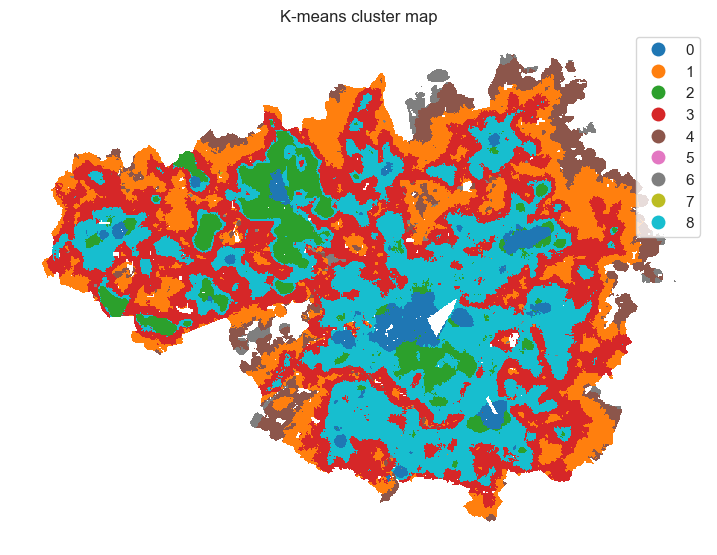

In [12]:
# Plotting results, 7 seems to be okay here
popgridsub["Kmeans_cluster_label"] = cgram_kmeans.labels[9]
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
popgridsub.plot(
    column="Kmeans_cluster_label",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.title("K-means cluster map")
plt.show()

### 3. Loading and running Gaussian Mixture Models (GMM) from Clustergram Pickle with 9 clusters

In [20]:
with open('clustergram_gmm.pickle','rb') as f:
    cgram_gmm = pickle.load(f)

c:\Users\Gebruiker\anaconda3\envs\ssml\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator PCA from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<AxesSubplot: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

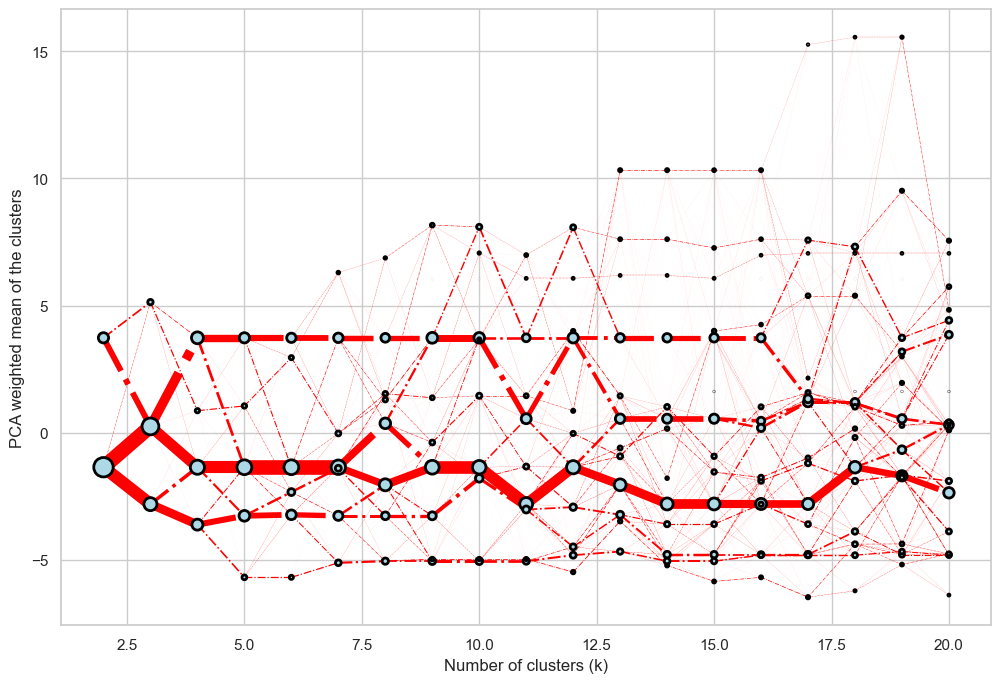

In [21]:
# plot cgram
sb.set(style='whitegrid')

cgram_gmm.plot(
    size=0.5,
    linewidth=0.5,
    cluster_style={"color": "lightblue", "edgecolor": "black"},
    line_style={"color": "red", "linestyle": "-."},
    figsize=(12, 8)
)

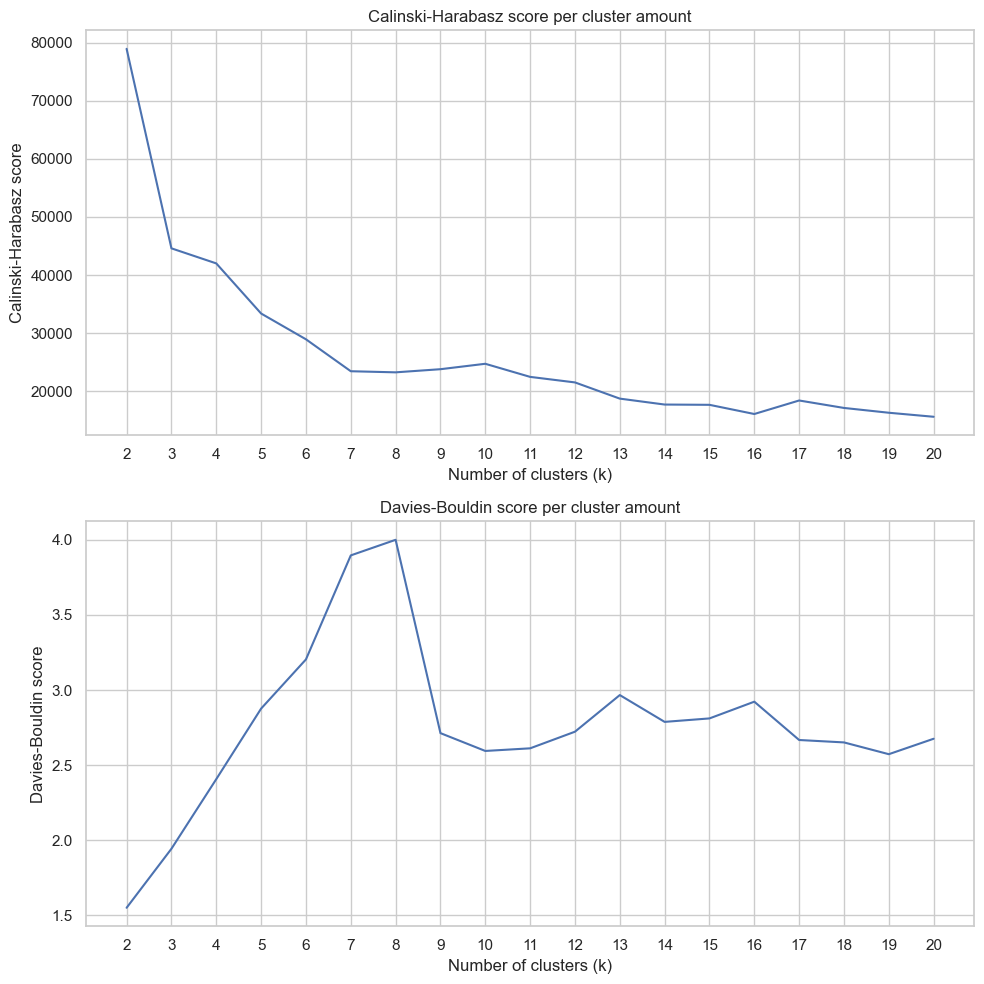

In [22]:
# getting the scores
gmmch = cgram_gmm.calinski_harabasz_score()
gmmdb = cgram_gmm.davies_bouldin_score()

# Plotting both the Silhouette score and the Calinski-Harabasz score per cluster amount
fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].plot(K, gmmch)
axs[0].set_xlabel("Number of clusters (k)")
axs[0].set_ylabel("Calinski-Harabasz score")
axs[0].grid(True)
axs[0].set_xticks(range(2,21))
axs[0].set_title('Calinski-Harabasz score per cluster amount')
axs[1].plot(K, gmmdb)
axs[1].set_xlabel("Number of clusters (k)")
axs[1].set_ylabel("Davies-Bouldin score")
axs[1].grid(True)
axs[1].set_xticks(range(2,21))
axs[1].set_title('Davies-Bouldin score per cluster amount')
plt.tight_layout()
plt.show()

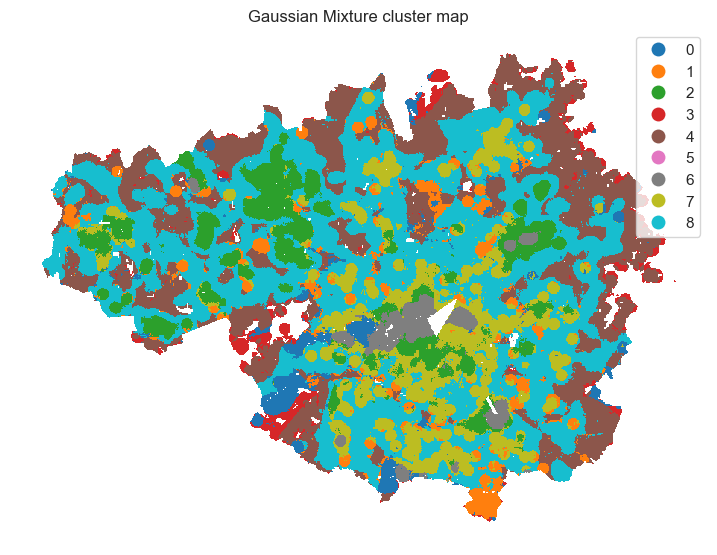

In [23]:
# Plotting results, 10 seems okay here
popgridsub["GMM_cluster_label"] = cgram_gmm.labels[9]
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
popgridsub.plot(
    column="GMM_cluster_label",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.title("Gaussian Mixture cluster map")
plt.show()

In [24]:
popgridsub

,index,population,buffer_pop_density,intersection_count,street_length_avg,circuity_avg,intersection_density_km,street_density_km,streets_per_node_counts.2,streets_per_node_counts.3,...,dist_to_fast_food,dist_to_water_bodies,dist_to_doctor_offices,dist_to_pharmacies,dist_to_gambling,land_diversity,building_density,geometry,Kmeans_cluster_label,GMM_cluster_label
0,25,11,1774.946202,45.0,45.947771,1.112321,126.103015,9013.126107,0.0,41.0,...,505.441,6372.629,2264.807,2105.590,6115.774,2.080081,0.000664,"POLYGON ((370373.657 415055.293, 370421.465 41...",3,8
1,26,4,1921.345881,58.0,47.351674,1.128668,139.248416,10117.835493,0.0,53.0,...,510.806,6377.994,2270.172,2110.955,6121.139,2.083642,0.000768,"POLYGON ((370421.465 415055.293, 370484.264 41...",3,8
2,27,13,2277.193386,81.0,46.003520,1.122975,166.824320,12032.867225,0.0,77.0,...,510.806,6377.994,2270.172,2110.955,6121.139,2.083642,0.000923,"POLYGON ((370484.264 415055.293, 370547.062 41...",3,8
3,28,9,2632.487996,99.0,45.763654,1.109067,189.541753,13931.167581,0.0,93.0,...,510.806,6377.994,2270.172,2110.955,6121.139,2.022346,0.001002,"POLYGON ((370547.062 415055.293, 370609.860 41...",3,8
4,29,10,2850.280072,115.0,45.568070,1.096260,250.844180,18487.567239,0.0,109.0,...,413.144,6280.721,2172.899,2013.682,6023.866,1.920227,0.001020,"POLYGON ((370609.860 415055.293, 370672.659 41...",3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308473,324719,0,2.349186,2.0,342.389000,1.262166,25.350642,13019.671681,0.0,1.0,...,4637.639,3320.752,5662.388,4399.955,12637.476,0.000000,0.000000,"POLYGON ((396105.987 415118.092, 396168.786 41...",4,4
308474,324720,0,2.397778,2.0,342.389000,1.262166,25.350642,13019.671681,0.0,1.0,...,4637.639,3320.752,5662.388,4399.955,12637.476,0.000000,0.000000,"POLYGON ((396168.786 415118.092, 396231.584 41...",4,4
308475,324721,0,2.449702,2.0,342.389000,1.262166,25.350642,13019.671681,0.0,1.0,...,4637.639,3320.752,5662.388,4399.955,12637.476,0.000000,0.000000,"POLYGON ((396231.584 415118.092, 396294.382 41...",4,4
308476,324722,0,2.507433,2.0,342.389000,1.262166,25.350642,13019.671681,0.0,1.0,...,4637.639,3320.752,5662.388,4399.955,12637.476,0.000000,0.000000,"POLYGON ((396294.382 415118.092, 396357.181 41...",4,4
